In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import requests
import json
import time
from datetime import datetime 
import sqlalchemy as sqla
from sqlalchemy import create_engine
import csv
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

Commented out code was used to import data from databases and save them to csv files.

In [ ]:
#URI = "dublinbikesdatabase.ck8yyafvjq4p.eu-west-1.rds.amazonaws.com"
#PORT = "3306"
#DB = "dbbikes"
#USER = "Group26"
#PASSWORD = "Grouptwentysix"

#engine = create_engine("mysql+mysqldb://{}:{}@{}:{}/{}".format(USER, PASSWORD, URI, PORT, DB), echo=True)

In [ ]:
#conn = engine.connect()
#result = conn.execute("SELECT * FROM availability")
#data = result.fetchall()
#conn.close()#

In [ ]:
#with open("availability.csv", "w", newline="") as f:
    #writer = csv.writer(f)
    #writer.writerows(data)

In [ ]:
#conn = engine.connect()
#result = conn.execute("SELECT * FROM weather")
#data = result.fetchall()
#conn.close()

In [ ]:
#with open("weather.csv", "w", newline="") as f:
    #writer = csv.writer(f)
    #writer.writerows(data)

In [2]:
dfa = pd.read_csv('availability.csv', names=['number', 'available_bikes', 'available_bike_stands', 'time'])

In [3]:
dfw = pd.read_csv('weather.csv', names=['id', 'main', 'description', 'temp', 'feels_like', 'humidity', 'visibility',
                                            'speed','deg','all','dt'])

In [8]:
dfw

,id,main,description,temp,feels_like,humidity,speed,dt
0,803,Clouds,broken clouds,280.37,276.45,77,7.20,0
1,803,Clouds,broken clouds,280.37,276.45,77,7.20,0
2,803,Clouds,broken clouds,280.37,276.45,77,7.20,0
3,803,Clouds,broken clouds,280.37,276.45,77,7.20,0
4,803,Clouds,broken clouds,280.48,276.59,78,7.20,0
...,...,...,...,...,...,...,...,...
10278,803,Clouds,broken clouds,280.69,277.83,90,4.63,1680768000
10279,803,Clouds,broken clouds,280.69,277.83,90,4.63,1680768000
10280,803,Clouds,broken clouds,280.80,277.96,91,4.63,1680768000
10281,803,Clouds,broken clouds,280.80,277.96,91,4.63,1680768000


In [5]:
dfw.drop(['visibility','deg','all','deg','all'], inplace=True, axis=1)

In [ ]:
startTime = 1677668400
endTime = 1680771600
times = np.linspace(startTime,endTime,863)

In [ ]:
for i in dfa.index:
    if dfa['number'][i] == 1:
        print(dfa.loc[i])
        print()

In [6]:
dfw['dt'] = pd.to_datetime(dfw['dt'], unit='s')
dfw['dt'] = dfw['dt'].dt.floor('H') # Drop to nearest hour
dfw['dt'] = dfw['dt'].apply(lambda x: int(x.timestamp()))

dfa['time'] = pd.to_datetime(dfa['time'], unit='s')
dfa['time'] = dfa['time'].dt.floor('H') # Drop to nearest hour
dfa['time'] = dfa['time'].apply(lambda x: int(x.timestamp()))
dfa.tail(10)

,number,available_bikes,available_bike_stands,time
1174535,3,10,10,1680768000
1174536,40,15,6,1680768000
1174537,29,3,26,1680768000
1174538,103,4,36,1680768000
1174539,28,19,11,1680768000
1174540,39,0,20,1680768000
1174541,83,13,27,1680768000
1174542,92,25,15,1680768000
1174543,21,10,20,1680768000
1174544,88,14,15,1680768000


In [93]:
station_data = {}
grouped = dfa.groupby('number')

for name, group in grouped:
    new_station_df = pd.DataFrame(group, columns=['number','available_bikes','available_bike_stands','time'])
    station_data[name] = new_station_df

In [9]:
weather_data = {}
grouped = dfw.groupby('dt')

for name, group in grouped:
    new_station_df = pd.DataFrame(group, columns=['id','main','description','temp','feels_like','humidity','speed','dt'])
    weather_data[name] = new_station_df

weather_data = {f'df{key}': value for key, value in weather_data.items()}
for name, df in weather_data.items():
    globals()[name] = df

In [13]:
cleanedWeather = pd.DataFrame(columns=['Time', 'Weather', 'Description', 'Temp', 'Feels Like', 'Humidity', 'Wind Speed'])

for key, value in weather_data.items():
    main_mode = value['main'].mode()[0]
    desc_mode = value['description'].mode()[0]
    temp_mean = round(value['temp'].mean(),2)
    feels_mean = round(value['feels_like'].mean(),2)
    humidity_mean = round(value['humidity'].mean(),2)
    speed_mean = round(value['speed'].mean(),2)
    key = key[2:]
    cleanedWeather.loc[len(cleanedWeather)] = [key, main_mode, desc_mode, temp_mean, feels_mean, humidity_mean, speed_mean]

In [14]:
cleanedWeather

,Time,Weather,Description,Temp,Feels Like,Humidity,Wind Speed
0,0,Clouds,broken clouds,281.03,277.42,74.64,6.85
1,1677682800,Clouds,broken clouds,280.91,277.45,74.20,6.27
2,1677686400,Clouds,broken clouds,280.80,277.38,74.00,6.09
3,1677690000,Clouds,scattered clouds,280.53,276.96,76.18,6.31
4,1677693600,Clouds,broken clouds,280.23,277.20,78.33,4.80
...,...,...,...,...,...,...,...
854,1680753600,Rain,light intensity shower rain,280.46,277.53,87.45,4.68
855,1680757200,Clouds,broken clouds,280.50,278.16,86.73,3.56
856,1680760800,Rain,light intensity shower rain,280.70,278.36,88.42,3.79
857,1680764400,Clouds,broken clouds,280.63,278.03,89.92,4.07


In [15]:
# Takes a while to run
cleanedStations = pd.DataFrame(columns=['Station','Available Bikes','Available Stands','Time'])
for station in station_data.values():
    grouped = station.groupby('time')
    for time, group in grouped:
        mean_bikes = round(group['available_bikes'].mean())
        mean_stands = round(group['available_bike_stands'].mean())
        cleanedStations.loc[len(cleanedStations)] = [group.iloc[0]['number'], mean_bikes, mean_stands, time]

In [16]:
cleanedStations.dtypes

Station             int64
Available Bikes     int64
Available Stands    int64
Time                int64
dtype: object

In [17]:
cleanedWeather['Time'] = cleanedWeather['Time'].astype('int64')
cleanedWeather.dtypes

Time             int64
Weather         object
Description     object
Temp           float64
Feels Like     float64
Humidity       float64
Wind Speed     float64
dtype: object

In [18]:
cleanedStations

,Station,Available Bikes,Available Stands,Time
0,1,21,9,1677668400
1,1,22,8,1677672000
2,1,22,8,1677675600
3,1,23,8,1677679200
4,1,23,8,1677682800
...,...,...,...,...
98483,507,1,0,1678449600
98484,507,1,0,1678453200
98485,507,1,0,1678456800
98486,507,1,0,1678460400


In [19]:
df = pd.merge(cleanedStations, cleanedWeather, on='Time')

In [20]:
df = df.sort_values(['Station', 'Time'], ascending=[True, True])
df['Day'] = 'day'
df['Hour'] = 'hour'
df

,Station,Available Bikes,Available Stands,Time,Weather,Description,Temp,Feels Like,Humidity,Wind Speed,Day,Hour
0,1,23,8,1677682800,Clouds,broken clouds,280.91,277.45,74.20,6.27,day,hour
115,1,24,6,1677686400,Clouds,broken clouds,280.80,277.38,74.00,6.09,day,hour
230,1,19,12,1677690000,Clouds,scattered clouds,280.53,276.96,76.18,6.31,day,hour
345,1,17,14,1677693600,Clouds,broken clouds,280.23,277.20,78.33,4.80,day,hour
460,1,15,16,1677697200,Clouds,broken clouds,280.33,277.19,78.67,5.14,day,hour
...,...,...,...,...,...,...,...,...,...,...,...,...
24609,507,1,0,1678449600,Clouds,broken clouds,276.66,273.57,85.82,3.41,day,hour
24724,507,1,0,1678453200,Clouds,broken clouds,277.71,275.36,79.25,2.74,day,hour
24839,507,1,0,1678456800,Clouds,broken clouds,278.65,276.86,59.83,2.27,day,hour
24954,507,1,0,1678460400,Clouds,broken clouds,278.87,277.10,55.54,2.31,day,hour


In [21]:
for i in df.index:
    date = datetime.fromtimestamp(df['Time'][i])
    day = date.strftime("%A")
    hour = date.strftime("%H")
    x = df.loc[i, 'Day']
    df.loc[i, 'Day'] = x.replace(x, day)
    y = df.loc[i, 'Hour']
    df.loc[i, 'Hour'] = y.replace(y, hour)
df

,Station,Available Bikes,Available Stands,Time,Weather,Description,Temp,Feels Like,Humidity,Wind Speed,Day,Hour
0,1,23,8,1677682800,Clouds,broken clouds,280.91,277.45,74.20,6.27,Wednesday,15
115,1,24,6,1677686400,Clouds,broken clouds,280.80,277.38,74.00,6.09,Wednesday,16
230,1,19,12,1677690000,Clouds,scattered clouds,280.53,276.96,76.18,6.31,Wednesday,17
345,1,17,14,1677693600,Clouds,broken clouds,280.23,277.20,78.33,4.80,Wednesday,18
460,1,15,16,1677697200,Clouds,broken clouds,280.33,277.19,78.67,5.14,Wednesday,19
...,...,...,...,...,...,...,...,...,...,...,...,...
24609,507,1,0,1678449600,Clouds,broken clouds,276.66,273.57,85.82,3.41,Friday,12
24724,507,1,0,1678453200,Clouds,broken clouds,277.71,275.36,79.25,2.74,Friday,13
24839,507,1,0,1678456800,Clouds,broken clouds,278.65,276.86,59.83,2.27,Friday,14
24954,507,1,0,1678460400,Clouds,broken clouds,278.87,277.10,55.54,2.31,Friday,15


In [62]:
#df.to_csv('cleaned_training_dataset.csv', index=False)
df = pd.read_csv('cleaned_training_dataset.csv')
df.drop('Time', inplace=True, axis=1)
for i in df.index:
    if df['Day'][i] in ['Saturday','Sunday']:
        x = df.loc[i, 'Day']
        y = 'Weekend'
        df.loc[i, 'Day'] = x.replace(x, y)
    elif df['Day'][i] not in ['Saturday','Sunday']:
        x = df.loc[i, 'Day']
        y = 'Weekday'
        df.loc[i, 'Day'] = x.replace(x, y)
df[['Station','Temp','Weather','Description','Day']] =\
                df[['Station','Temp','Weather','Description','Day']].astype('category')
df

,Station,Available Bikes,Available Stands,Weather,Description,Temp,Feels Like,Humidity,Wind Speed,Day,Hour
0,1,23,8,Clouds,broken clouds,280.91,277.45,74.20,6.27,Weekday,15
1,1,24,6,Clouds,broken clouds,280.80,277.38,74.00,6.09,Weekday,16
2,1,19,12,Clouds,scattered clouds,280.53,276.96,76.18,6.31,Weekday,17
3,1,17,14,Clouds,broken clouds,280.23,277.20,78.33,4.80,Weekday,18
4,1,15,16,Clouds,broken clouds,280.33,277.19,78.67,5.14,Weekday,19
...,...,...,...,...,...,...,...,...,...,...,...
98025,507,1,0,Clouds,broken clouds,276.66,273.57,85.82,3.41,Weekday,12
98026,507,1,0,Clouds,broken clouds,277.71,275.36,79.25,2.74,Weekday,13
98027,507,1,0,Clouds,broken clouds,278.65,276.86,59.83,2.27,Weekday,14
98028,507,1,0,Clouds,broken clouds,278.87,277.10,55.54,2.31,Weekday,15


In [32]:
#df.to_csv('cleaned_training_dataset_2.csv', index=False)
df = pd.read_csv('cleaned_training_dataset_2.csv')

In [33]:
df = df[df['Station'] != 507]

In [4]:
df

,Station,Available Bikes,Available Stands,Weather,Description,Temp,Feels Like,Humidity,Wind Speed,Day,Hour
0,1,23,8,Clouds,broken clouds,280.91,277.45,74.20,6.27,Weekday,15
1,1,24,6,Clouds,broken clouds,280.80,277.38,74.00,6.09,Weekday,16
2,1,19,12,Clouds,scattered clouds,280.53,276.96,76.18,6.31,Weekday,17
3,1,17,14,Clouds,broken clouds,280.23,277.20,78.33,4.80,Weekday,18
4,1,15,16,Clouds,broken clouds,280.33,277.19,78.67,5.14,Weekday,19
...,...,...,...,...,...,...,...,...,...,...,...
97807,117,0,40,Rain,light intensity shower rain,280.46,277.53,87.45,4.68,Weekday,5
97808,117,0,40,Clouds,broken clouds,280.50,278.16,86.73,3.56,Weekday,6
97809,117,1,39,Rain,light intensity shower rain,280.70,278.36,88.42,3.79,Weekday,7
97810,117,2,38,Clouds,broken clouds,280.63,278.03,89.92,4.07,Weekday,8


In [6]:
weather_data = {}
grouped = dfw.groupby('dt')

for name, group in grouped:
    new_station_df = pd.DataFrame(group, columns=['id','main','description','temp','feels_like','humidity','speed','dt'])
    weather_data[name] = new_station_df

weather_data = {f'df{key}': value for key, value in weather_data.items()}
for name, df in weather_data.items():
    globals()[name] = df

NameError: name 'dfw' is not defined

In [7]:
stationDataframes = {}
for i in sorted(pd.unique(df["Station"].ravel())):
    newDB = df[df['Station'] == i]
    name = str(i)
    stationDataframes[name] = newDB

In [8]:
for key, value in stationDataframes.items():
    DF = pd.get_dummies(value, columns=['Station','Weather', 'Description', 'Day','Hour'])
    X = DF.drop(['Available Bikes', 'Available Stands'], axis=1)
    y_bikes = DF['Available Bikes']
    y_stands = DF['Available Stands']
    
    X_train, X_test, y_train_bikes, y_test_bikes, y_train_stands, y_test_stands = train_test_split(X, y_bikes, y_stands, \
                                                    test_size=0.2, random_state=36)
    bikesModel = RandomForestRegressor(n_estimators=100, random_state=36)
    standsModel = RandomForestRegressor(n_estimators=100, random_state=36)
    
    bikesModel.fit(X_train, y_train_bikes)
    standsModel.fit(X_train, y_train_stands)
    
    #bikesFile = f"bikes_station_{key}.pkl"
    #standsFile =f"stands_station_{key}.pkl"
    
    #pickle.dump(bikesModel, open(bikesFile, 'wb'))
    #pickle.dump(standsModel, open(standsFile, 'wb'))
    
    y_pred_bikes = bikesModel.predict(X_test)
    y_pred_stands = standsModel.predict(X_test)
    mse_bikes = mean_squared_error(y_test_bikes, y_pred_bikes)
    mse_stands = mean_squared_error(y_test_stands, y_pred_stands)
    print(f'Station {key} MSE for available bikes:', mse_bikes)
    print(f'Station {key} MSE for available stands:', mse_stands)
    print(r2_score(y_test_stands, y_pred_stands))
    print(r2_score(y_test_bikes, y_pred_bikes))

Station 1 MSE for available bikes: 34.276972093023254
Station 1 MSE for available stands: 33.18795581395349
0.6169194110633198
0.6031729175332972
Station 2 MSE for available bikes: 13.458223255813955
Station 2 MSE for available stands: 13.726746511627907
0.4203884674891668
0.42681497212880637
Station 3 MSE for available bikes: 9.18896511627907
Station 3 MSE for available stands: 8.986486046511628
0.6085583575294624
0.6000518696373716
Station 4 MSE for available bikes: 12.868076744186045
Station 4 MSE for available stands: 13.533974418604652
0.6456918628142424
0.6594552539040311
Station 5 MSE for available bikes: 46.17834186046511
Station 5 MSE for available stands: 46.60964186046511
0.7629653720665904
0.7643589494660414
Station 6 MSE for available bikes: 13.347818604651161
Station 6 MSE for available stands: 17.560448837209304
0.5858854827087039
0.6335243917469133
Station 7 MSE for available bikes: 26.535974418604653
Station 7 MSE for available stands: 26.77036046511628
0.4549250057124

KeyboardInterrupt: 

Ignore the rest of this, it was initially used to make a single model.

In [34]:
df = pd.get_dummies(df, columns=['Station', 'Weather', 'Description', 'Day','Hour']) # Creates binary indicator columns from categorical variables
X = df.drop(['Available Bikes', 'Available Stands'], axis=1)
y_bikes = df['Available Bikes']
y_stands = df['Available Stands']

X_train, X_test, y_train_bikes, y_test_bikes, y_train_stands,y_test_stands = train_test_split(X, y_bikes, y_stands, \
                                                    test_size=0.2, random_state=36) # random_state is the random seed

# Create a random forest regressor for each target variable with 200 trees
bikesModel = RandomForestRegressor(n_estimators=150, random_state=36)
standsModel = RandomForestRegressor(n_estimators=150, random_state=36)

# Fit the model to the training data
bikesModel.fit(X_train, y_train_bikes)
standsModel.fit(X_train, y_train_stands)

RandomForestRegressor(n_estimators=150, random_state=36)

In [35]:
# Evaulate model performance
y_pred_bikes = bikesModel.predict(X_test)
y_pred_stands = standsModel.predict(X_test)
# mse is mean squared error, average of the squared differences between the predicted and actual target values
# mse removes negative values and gives more weight to larger errors
mse_bikes = mean_squared_error(y_test_bikes, y_pred_bikes)
mse_stands = mean_squared_error(y_test_stands, y_pred_stands)
print('MSE for available bikes:', mse_bikes)
print('MSE for available stands:', mse_stands)

MSE for available bikes: 32.04547051747346
MSE for available stands: 34.52665474620457


In [83]:
numbers = []
for i in sorted(pd.unique(dfa["number"].ravel())):
    x = 0
    for j in dfa.index:
        if dfa['number'][j] == i:
            x+=1
    numbers.append([i,x])

In [87]:
print(numbers)

[[1, 10280], [2, 10280], [3, 10280], [4, 10280], [5, 10280], [6, 10280], [7, 10280], [8, 10280], [9, 10280], [10, 10280], [11, 10280], [12, 10280], [13, 10280], [14, 10280], [15, 10280], [16, 10280], [17, 10280], [18, 10280], [19, 10280], [20, 10280], [21, 10280], [22, 10280], [23, 10280], [24, 10280], [25, 10280], [26, 10280], [27, 10280], [28, 10280], [29, 10280], [30, 10280], [31, 10280], [32, 10280], [33, 10280], [34, 10280], [35, 10280], [36, 10280], [37, 10280], [38, 10280], [39, 10280], [40, 10280], [41, 10280], [42, 10280], [43, 10280], [44, 10280], [45, 10280], [47, 10280], [48, 10280], [49, 10280], [50, 10280], [51, 10280], [52, 10280], [53, 10280], [54, 10280], [55, 10280], [56, 10280], [57, 10280], [58, 10280], [59, 10280], [60, 10280], [61, 10280], [62, 10280], [63, 10280], [64, 10280], [65, 10280], [66, 10280], [67, 10280], [68, 10280], [69, 10280], [71, 10280], [72, 10280], [73, 10258], [74, 10280], [75, 10280], [76, 10280], [77, 10280], [78, 10280], [79, 10280], [80, 10

In [48]:
from sklearn.metrics import mean_absolute_error, r2_score
print('MAE: ', mean_absolute_error(y_test_bikes, y_pred_bikes))
r2_score(y_test_bikes, y_pred_bikes)

MAE:  4.1929744926647246


0.6248499350483787

In [49]:
print('MAE: ', mean_absolute_error(y_test_stands, y_pred_stands))
r2_score(y_test_stands, y_pred_stands)

MAE:  4.332589071205848


0.695868336650749

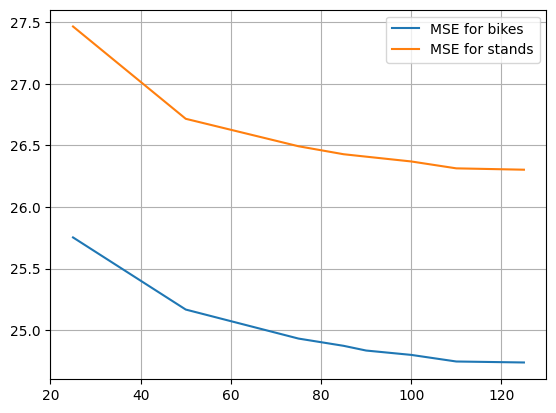

In [38]:
x = [25,50,75,85,90,100,110,125]
#bikes = [25.753198425599344,25.167759218933703,24.93225011842083,24.873444138509477,24.835113646761997,24.67081842253233,
 #       24.746169151328427,24.738200794561163]
#stands =[27.465236047640957,26.715944568828917,26.493102784735356,26.428388446730615,26.408722291955776,25.54733317998262,
 #       26.313751735756867,26.30280572263968]

bikes = [25.753198425599344,25.167759218933703,24.93225011842083,24.873444138509477,24.835113646761997,24.799739676941165,
        24.746169151328427,24.738200794561163]
stands =[27.465236047640957,26.715944568828917,26.493102784735356,26.428388446730615,26.408722291955776,26.369706737207995,
        26.313751735756867,26.30280572263968]

plt.plot(x, bikes, label='MSE for bikes')
plt.plot(x, stands, label = 'MSE for stands')
plt.legend()
plt.grid()

Including hour

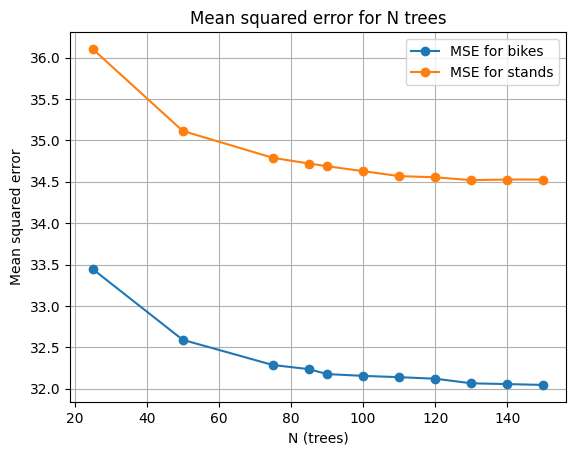

In [40]:
x = [25,50,75,85,90,100,110,120,130,140,150]
bikes = [33.44606704493176,32.59017925676021,32.28575464567466,32.23600461078015,32.1765787519019,32.15466820528549,
        32.13904959311367,32.12038807669808,32.0651625623422,32.055383475886906,32.04547051747346]
stands = [36.104179113632874,35.11330926749476,34.7886445046488,34.719842531634555,34.68711069586515,34.62764490620048,
         34.56794423441452,34.553297633145334,34.51903120460162,34.52660574366229,34.52665474620457]

plt.plot(x, bikes, marker = 'o', linestyle = '-', label='MSE for bikes')
plt.plot(x, stands, marker = 'o', linestyle = '-', label = 'MSE for stands')
plt.title('Mean squared error for N trees')
plt.xlabel('N (trees)')
plt.ylabel('Mean squared error')
plt.legend()
plt.grid()
plt.savefig('ModelMSE.png')